In [1]:
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms
from torchvision import datasets
import torchvision.models as models

from sklearn.metrics import f1_score, classification_report
import numpy as np

In [2]:
MODEL_PATH = "/Users/malgosielska/Studies/Sem 1 TAI/Projekt wdrozeniowy/plantie-backend/plant_disease_classification/plant_disease_model_v2.pth"
CLASS_INDICES_PATH = "/Users/malgosielska/Studies/Sem 1 TAI/Projekt wdrozeniowy/plantie-backend/plant_disease_classification/class_indices.json"

train_dir = "/Users/malgosielska/Studies/Sem 1 TAI/Projekt wdrozeniowy/plantie-backend/plantvillage_dataset/train_balanced"
test_dir = "/Users/malgosielska/Studies/Sem 1 TAI/Projekt wdrozeniowy/plantie-backend/plantvillage_dataset/val_balanced"

train_dir, test_dir

('/Users/malgosielska/Studies/Sem 1 TAI/Projekt wdrozeniowy/plantie-backend/plantvillage_dataset/train_balanced',
 '/Users/malgosielska/Studies/Sem 1 TAI/Projekt wdrozeniowy/plantie-backend/plantvillage_dataset/val_balanced')

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
device

device(type='mps')

In [4]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(size=(224, 224)),
    ]
)

In [5]:
from torch.utils.data import random_split

train_data = datasets.ImageFolder(root=train_dir, transform=transform)
test_data = datasets.ImageFolder(root=test_dir, transform=transform)

total_len = len(test_data)
val_len = total_len // 2
test_len = total_len - val_len

val_data, test_data = random_split(test_data, [val_len, test_len])

train_data, len(val_data), len(test_data)

(Dataset ImageFolder
     Number of datapoints: 18965
     Root location: /Users/malgosielska/Studies/Sem 1 TAI/Projekt wdrozeniowy/plantie-backend/plantvillage_dataset/train_balanced
     StandardTransform
 Transform: Compose(
                ToTensor()
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
            ),
 1808,
 1809)

In [6]:
class_names = train_data.classes
num_classes = len(class_names)
class_dict = train_data.class_to_idx
class_dict, num_classes

({'Apple___Apple_scab': 0,
  'Apple___Black_rot': 1,
  'Apple___Cedar_apple_rust': 2,
  'Apple___healthy': 3,
  'Blueberry___healthy': 4,
  'Cherry_(including_sour)___Powdery_mildew': 5,
  'Cherry_(including_sour)___healthy': 6,
  'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7,
  'Corn_(maize)___Common_rust_': 8,
  'Corn_(maize)___Northern_Leaf_Blight': 9,
  'Corn_(maize)___healthy': 10,
  'Grape___Black_rot': 11,
  'Grape___Esca_(Black_Measles)': 12,
  'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13,
  'Grape___healthy': 14,
  'Orange___Haunglongbing_(Citrus_greening)': 15,
  'Peach___Bacterial_spot': 16,
  'Peach___healthy': 17,
  'Pepper,_bell___Bacterial_spot': 18,
  'Pepper,_bell___healthy': 19,
  'Potato___Early_blight': 20,
  'Potato___Late_blight': 21,
  'Potato___healthy': 22,
  'Raspberry___healthy': 23,
  'Soybean___healthy': 24,
  'Squash___Powdery_mildew': 25,
  'Strawberry___Leaf_scorch': 26,
  'Strawberry___healthy': 27,
  'Tomato___Bacterial_spot': 28,
  'Toma

In [7]:
import json

idx_to_class = {v: k for k, v in class_dict.items()}

with open(CLASS_INDICES_PATH, "w") as f:
    json.dump(idx_to_class, f)

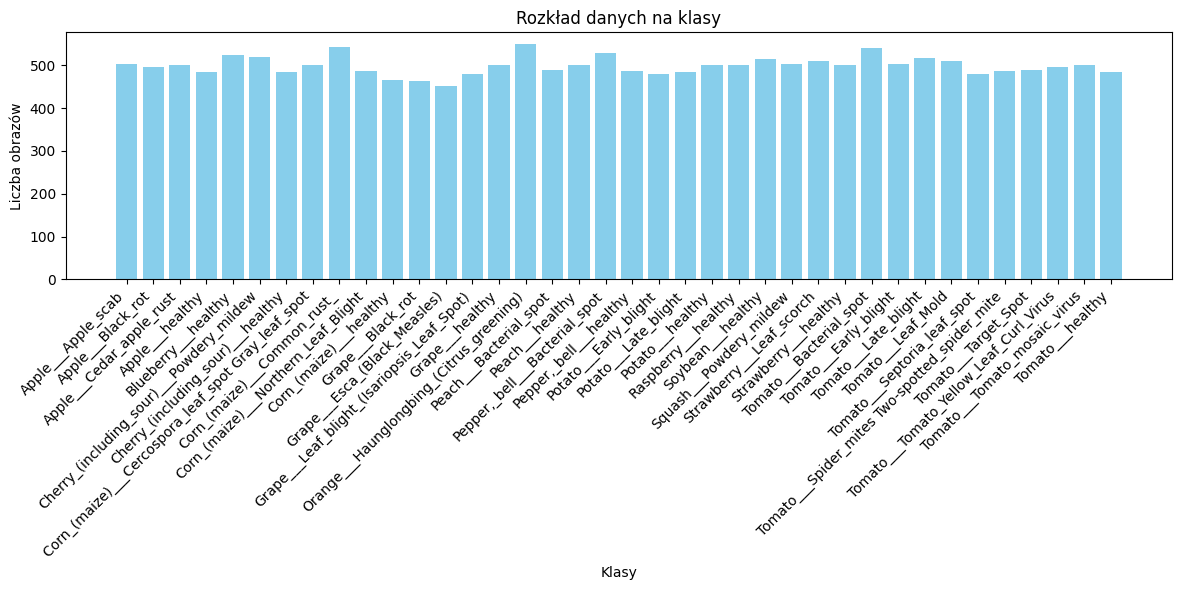

{'Apple___Apple_scab': 504,
 'Apple___Black_rot': 496,
 'Apple___Cedar_apple_rust': 500,
 'Apple___healthy': 485,
 'Blueberry___healthy': 524,
 'Cherry_(including_sour)___Powdery_mildew': 520,
 'Cherry_(including_sour)___healthy': 484,
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 500,
 'Corn_(maize)___Common_rust_': 544,
 'Corn_(maize)___Northern_Leaf_Blight': 487,
 'Corn_(maize)___healthy': 467,
 'Grape___Black_rot': 464,
 'Grape___Esca_(Black_Measles)': 453,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 481,
 'Grape___healthy': 500,
 'Orange___Haunglongbing_(Citrus_greening)': 550,
 'Peach___Bacterial_spot': 489,
 'Peach___healthy': 500,
 'Pepper,_bell___Bacterial_spot': 528,
 'Pepper,_bell___healthy': 486,
 'Potato___Early_blight': 479,
 'Potato___Late_blight': 484,
 'Potato___healthy': 500,
 'Raspberry___healthy': 500,
 'Soybean___healthy': 516,
 'Squash___Powdery_mildew': 503,
 'Strawberry___Leaf_scorch': 510,
 'Strawberry___healthy': 500,
 'Tomato___Bacterial_spot': 54

In [8]:
from collections import Counter
import matplotlib.pyplot as plt

# Zliczanie liczby wystąpień dla każdej klasy
labels = [label for _, label in train_data]
label_counts = Counter(labels)
mapped_counts = {class_names[i]: count for i, count in label_counts.items()}

# Tworzenie wykresu słupkowego
plt.figure(figsize=(12, 6))  # Zwiększenie szerokości wykresu
plt.bar(mapped_counts.keys(), mapped_counts.values(), color='skyblue')

# Dostosowanie etykiet na osi X
plt.xlabel("Klasy")
plt.ylabel("Liczba obrazów")
plt.title("Rozkład danych na klasy")

# Obrót etykiet na osi X o 45 stopni z mniejszym odstępem
plt.xticks(rotation=45, ha='right', fontsize=10)  # ha='right' wyrównuje tekst do prawej
plt.tight_layout()

# Wyświetlanie wykresu
plt.show()

mapped_counts


In [9]:
BATCH_SIZE = 32
NUM_WORKERS = 2

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=32, shuffle=True, num_workers=NUM_WORKERS
)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=32, shuffle=True, num_workers=NUM_WORKERS
)
val_loader = torch.utils.data.DataLoader(
    val_data, batch_size=32, shuffle=True, num_workers=NUM_WORKERS
)

len(train_loader), len(test_loader), len(val_loader), NUM_WORKERS

(593, 57, 57, 2)

In [10]:
model = models.regnet_y_400mf(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, num_classes)

model.to(device)

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 48, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=6, bias=False)
            

In [11]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import copy

num_epoch = 10
patience = 3  # ile epok czekamy bez poprawy
best_val_loss = float('inf')
epochs_no_improve = 0

train_losses = []
val_losses = []
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epoch):
    model.train()
    print(f"\nEpoch {epoch + 1} / {num_epoch}")
    running_loss = 0.0

    # Trening
    for inputs, labels in tqdm(train_loader, desc=f"Training {epoch + 1}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    print(f"Train Loss: {train_loss:.4f}")

    # Walidacja
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Validating {epoch + 1}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            val_running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss = val_running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)

    print(f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}")

    # Early stopping & zapisywanie najlepszego modelu
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
        print("✅ Better model found and saved.")
    else:
        epochs_no_improve += 1
        print(f"⚠️ No improvement. Patience: {epochs_no_improve}/{patience}")

        if epochs_no_improve >= patience:
            print("\n🛑 Early stopping triggered.")
            break

# Po treningu: wczytaj najlepszy model
model.load_state_dict(best_model_wts)
print("🎯 Best model weights loaded.")



Epoch 1 / 5


Training 1: 100%|██████████| 593/593 [02:10<00:00,  4.55it/s]


Train Loss: 0.0766


Validating 1: 100%|██████████| 57/57 [00:14<00:00,  3.81it/s]


Val Loss: 0.1316 | Val Accuracy: 0.9646
✅ Better model found and saved.

Epoch 2 / 5


Training 2:   2%|▏         | 10/593 [00:04<02:11,  4.44it/s]

In [ ]:
torch.save(model.state_dict(), MODEL_PATH)

In [ ]:
model = models.regnet_y_400mf(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)

/Users/malgosielska/Studies/Sem 1 TAI/Projekt wdrozeniowy/plantie-backend/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/malgosielska/Studies/Sem 1 TAI/Projekt wdrozeniowy/plantie-backend/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 48, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=6, bias=False)
            

In [ ]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for data in tqdm(test_loader, desc="Evaluating"):
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


Evaluating: 100%|██████████| 57/57 [00:15<00:00,  3.79it/s]


In [ ]:
# Accuracy
accuracy = 100 * np.mean(np.array(all_preds) == np.array(all_labels))
print(f"Accuracy: {accuracy:.2f}%")

# F1-score (dla klasyfikacji wieloklasowej użyj 'macro' lub 'weighted')
f1 = f1_score(all_labels, all_preds, average='macro')
print(f"F1 Score (macro): {f1:.4f}")

# Classification report (Precision, Recall, F1 dla każdej klasy)
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=test_data.dataset.classes))


Accuracy: 97.84%
F1 Score (macro): 0.9782

Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.98      1.00      0.99        60
                                 Apple___Black_rot       1.00      1.00      1.00        61
                          Apple___Cedar_apple_rust       0.96      1.00      0.98        24
                                   Apple___healthy       0.98      0.96      0.97        50
                               Blueberry___healthy       1.00      0.98      0.99        41
          Cherry_(including_sour)___Powdery_mildew       1.00      0.98      0.99        54
                 Cherry_(including_sour)___healthy       1.00      0.98      0.99        52
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.98      0.96      0.97        50
                       Corn_(maize)___Common_rust_       0.98      1.00      0.99        45
             

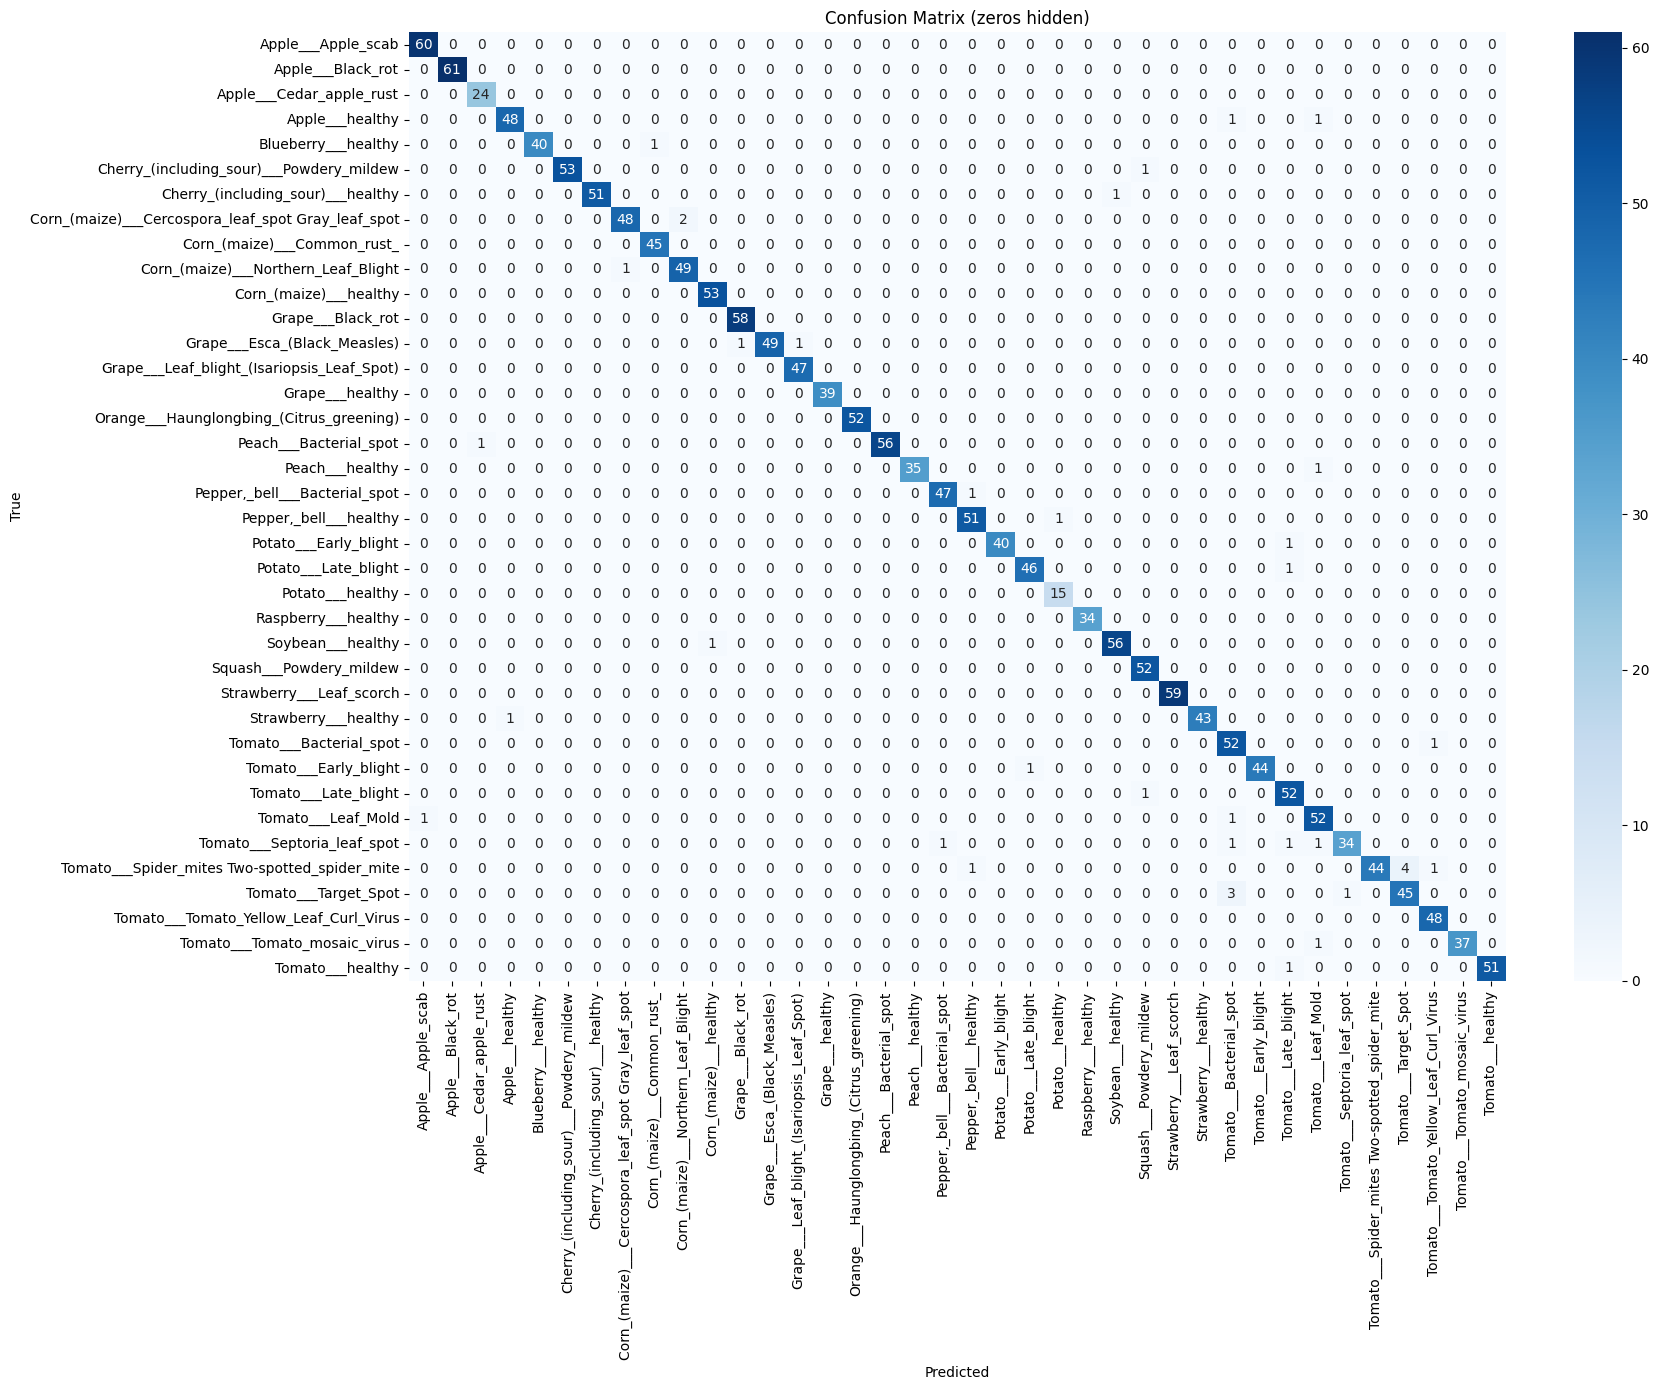

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Zakładam że masz all_preds i all_labels
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(18, 14))  # Większy rozmiar dla lepszej czytelności
sns.heatmap(cm, annot=cm, fmt='', cmap='Blues',
            xticklabels=test_data.dataset.classes,
            yticklabels=test_data.dataset.classes,
            cbar=True)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrixh')
plt.tight_layout()
plt.show()


In [ ]:
new_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)


def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = new_transform(image)
    image = image.unsqueeze(0)  
    return image.to(device)

image_paths = ["Apple___Apple_scab.JPG", "Apple___Black_rot.JPG"]
images = [load_image(path) for path in image_paths]

model.eval()
with torch.no_grad():
    for image in images:
        output = model(image)
        _, predicted = torch.max(output, 1)
        print(f"Predicted class: {class_names[predicted.item()]}")

Predicted class: Corn_(maize)___Common_rust_
Predicted class: Pepper,_bell___Bacterial_spot
